# Introduction to gravity classes

*pyshtools* has dedicated classes for working with the spherical harmonic coefficients of the gravitational potential. The classes `SHGravCoeffs`, `SHGravGrid`, `SHGravTensor`, and `SHGeoid` contain all the standard functionality of the classes `SHCoeffs` and `SHGrid`, but also allow for performing several standard operations related to gravitational fields. Specific operations include the computation of the geoid, the computation of the three vector components of the gravitational field, the computation of the gravity tensor and eigenvalues, and the computation of the gravitational potential from relief along an interface.

To start using the gravity classes, first import the standard *matplotlib* package, the *pyshtools* package, and the *pyshtools* subpackage *constant*:

In [1]:
%matplotlib inline
from __future__ import print_function # only necessary if using Python 2.x

import matplotlib.pyplot as plt

import pyshtools
from pyshtools import constant

Similiar to the *SHCoeffs* class, there are several ways that the *SHGravCoeffs* class can be initialized. Five methods are possible:
* `SHGravCoeffs.from_zeros()` - Set the degree 0 term to 1 and the other coefficients to zero.
* `SHGravCoeffs.from_array()` - Import a numpy array of spherical harmonic coefficients.
* `SHGravCoeffs.from_file()` - Read coefficients from a file.
* `SHGravCoeffs.from_random()` - Initialize the coefficients as random variables with a given power spectrum.
* `SHGravCoeffs.from_shape()` - Compute the gravitational potential coefficients from relief along an interface.

Unlike *SHCoeffs*, it is necessary to specify the attributes `gm`, `r0`, and optionally `omega`, for the GM, reference radius of the coefficients, and the angular rotation rate of the body. 

We start by reading the gravitational potential coefficients and errors for the planet Mars, where `r0` and `gm` are set by the first two elements of the file's header line. If the file does not contain a header with this information, these parameters should be specified explicitly by using the keywords `gm` and `r0`.

In [2]:
clm = pyshtools.SHGravCoeffs.from_file('../ExampleDataFiles/gmm3_120_sha.tab', errors=True)

/Users/lunokhod/SphericalHarmonics/shtools-git/pyshtools/shclasses/shgravcoeffs.py:482: RuntimeWarning: The degree 0 term of the file was not set. This will be set to 1.
  _warnings.warn(warnstr, category=RuntimeWarning)


Immediately, we receive a warning message because the file did not set the degree-0 spherical harmonic coefficient: when this occurs, *pyshtools* will automatically sets this value to unity. Next, by inspecting this class instance using the `info()` method, we notice that the GM and reference radius are in units of km, and not meters:

In [3]:
clm.info()

kind = 'real'
normalization = '4pi'
csphase = 1
lmax = 120
GM (m3 / s2) = 42828.37285418775
r0 (m) = 3396.0
Omega (rad / s) = None
errors are set: True
header = ['3.3960000000000000E+03', '0.4282837285418775E+05', '0.2380000000000000E+04', '120', '120', '1', '0.0000000000000000E+00', '0.0000000000000000E+00']


We change these two values to units of meters, and then using the `constant` submodule, we set the angular rotation rate of the planet. We also define variables for the planet's reference ellipsoid, such as the semimajor axis `a`, the flattening `f`, and the reference potential `u0`:

In [4]:
clm.r0 *= 1.e3
clm.gm *= 1.e9
clm.set_omega(constant.omega_mars.value)

a = constant.a_mars.value
f = constant.f_mars.value
u0 = constant.u0_mars.value

The spectrum of the function can be plotted using the methods `plot_spectrum()` and `plot_spectrum2d()`. Unlike *SHCoeffs* class instances, we have the option of plotting the power spectrum of the geoid (default), potential, or radial gravity, as specified by the optional parameter `function`:

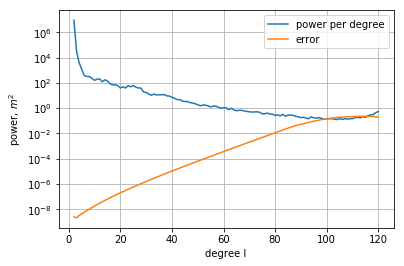

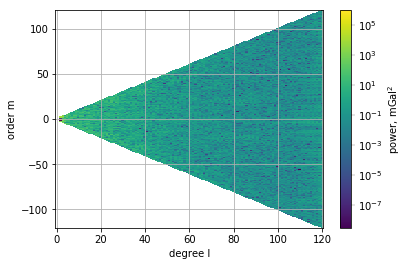

In [5]:
fig1, ax1 = clm.plot_spectrum(function='geoid')
fig2, ax2 = clm.plot_spectrum2d(function='gravity')

If the errors of the gravitational potential are set, `plot_spectrum()` will compute automatically and plot the error spectrum. For `plot_spectrum2d()`, the errors can be plotted by specifying `errors=True`. By default, the power associated with the degree 0 and 1 terms will not plotted, because the degree 0 term is orders of magnitude larger than the others, and the degree-1 terms are zero when in center-of-mass coordinates.

Next, we use the method `expand()` to calculate grids of the gravitational potential, the three vector components of the grvity field, and the total gravity disturbance. By default, these values are calculated on a sphere whose radius is equal to the reference radius `r0`. By specifying the parameters `a` and `f`, these quantities will instead be calculated on a flattened ellipsoid. It should be emphasized that the three vector components correspond to the three spherical coordinates unit vectors $\hat{r}$, $\hat{\theta}$, and $\hat{\phi}$, and not components that are perpendicular to the reference ellipsoid. By default, the normal gravity is removed from the total gravitational accelation, yielding the gravity disturbance.

The `expand()` method returns an `SHGravGrid` class instance. This class stores each of the four grids, `rad`, `theta`, `phi`, `total`, and `pot` as `SHGrid` class instances. The four gravity grids can be plotted using the method `plot()`:

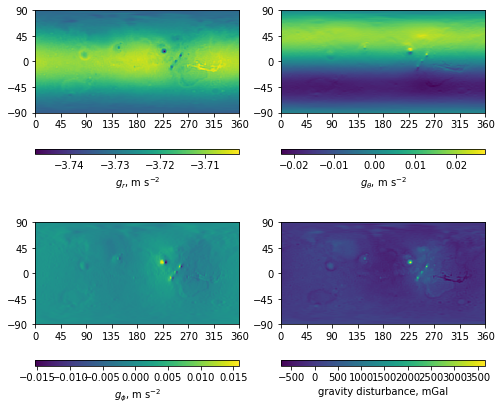

In [6]:
grav = clm.expand(lmax=95, a=a, f=f)
fig2, ax2 = grav.plot(show=False)
fig2.set_size_inches(7, 6)

Individual maps can be plotted using the corresponding methods `plot_rad()`, `plot_theta()`, `plot_phi()`, `plot_total()`, and `plot_pot()`. Here, we plot the total gravity disturbance, and use the parameters `vmin`, `vmax`, and `cmap` to set the minimum and maximum values and color scale, respectively:

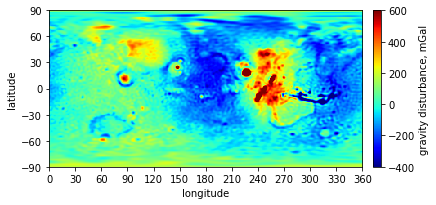

In [7]:
fig3, ax3 = grav.plot_total(vmin=-400, vmax=600, cmap='jet')

The geoid is computed using the `geoid()` method. By specifying the reference potential (in m/s), the height is calculted with respect to a sphere of reference radius `r0`. This method returns an `SHGeoid` class instance, where the geoid map is stored as an `SHGrid` class instance. 

Here, we compute the geoid on a grid that has a finer resolution than the potential coefficients by specifying the optional variable `lmax`. The reason for doing so is to compare this map directly to a higher resolution map of the shape of the planet later:

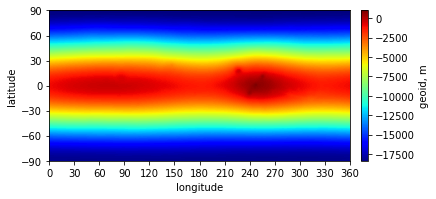

In [8]:
mars_geoid = clm.geoid(u0, lmax=719)
fig4, ax4 = mars_geoid.plot(cmap='jet')

In this image, the geoid height laregly reflects the rotational flattening of the planet. To calculate the geoid height with respect to a flattened ellipsoid, it is only necessary to specify the optional parameters `a` and `f`:

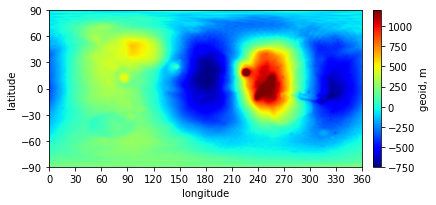

In [9]:
mars_geoid_ellipsoid = clm.geoid(u0, a=a, f=f, lmax=719)
fig5, ax5 = mars_geoid_ellipsoid.plot(vmin=-750, vmax=1200, cmap='jet')

With the geoid calculated, we next compute a map of the planet's surface relief with respect to the geoid. First, we read in the spherical harmonic coefficients of the shape of the planet and expand this onto a grid. Then, we subtract the geoid height and the geoid reference radius from the shape to yield a topographic map:

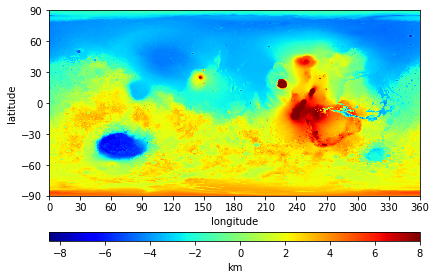

In [10]:
shape = pyshtools.SHCoeffs.from_file('../ExampleDataFiles/MarsTopo719.shape')
shape_grid = shape.expand(grid='DH2')
topo_grid = (shape_grid - mars_geoid.a - mars_geoid.geoid)/1.e3
fig6, ax6 = topo_grid.plot(colorbar=True, cb_label='km', cb_orientation='horizontal', cmap='jet', vmin=-8.5, vmax=8.)

Next, we remove the gravitational attraction of the surface topography from the free-air gravity to obtain the Bouguer anomaly. Using the `SHGravCoeffs.from_shape()` method, the gravitational attraction corresponding to relief with respect to a spherical interface is obtained. This method uses the finite-amplitude technique described in Wieczorek (2015), and can account for either a constant density contrast along the interface, or a density contrast that varies laterally. The density constrast can be specified either as a scalar, or an `SHGrid` or `SHCoeffs` class instance. For this example, we set the density contrast equal to a constant, specify the GM of the planet, and set the maximum spherical harmonic degree to compute:

In [11]:
bc = pyshtools.SHGravCoeffs.from_shape(shape, rho=2800., gm=clm.gm, lmax=120)

Inspection of `bc` shows that the reference radius of the Bouguer correction corresponds to the reference radius of the planet, which is different from the reference radius of the gravitational potential coefficeints `clm`.

In [12]:
bc.info()

kind = 'real'
normalization = '4pi'
csphase = 1
lmax = 120
GM (m3 / s2) = 42828372854187.75
r0 (m) = 3389500.12207057
Omega (rad / s) = None
errors are set: False
header = None


To reference the coefficients `bc` to a different radius by upword continuation, it is only necessary to use the method `change_ref()` and specify the new reference radius. After doing so, we subtract the Bouguer correction from the free-air gravitational potential coefficients, yielding the Bouguer anomaly:

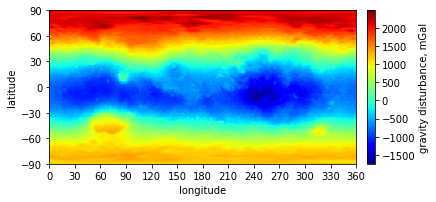

In [13]:
bc = bc.change_ref(r0=clm.r0)
bouguer = clm - bc
bouguer_grid = bouguer.expand(lmax=95, a=a, f=f)
fig7, ax7 = bouguer_grid.plot_total(cmap='jet')

It is immediately obvious that the Bouguer anomaly plot has a large component associated with the flattening of the planet: This is simply because the Bouguer correction was computed for relief with respect to a sphere, and not with respect to a flattened ellipsoid.

We next caclulate the gravity "gradient" tensor using the method `tensor()`. By default, this method sets the degree-0 term of the gravitational potential coefficients to zero, but the full tensor can be calculated by specifying `degree0=True`. The `tensor()` method computes all 9 components of the gravity tensor and returns an `SHGravTensor` class instance. Similar to the `SHGravGrid` and `SHGeoid` classes, each of the 9 components are stored as an `SHGrid` class instance with names `vxx`, `vxy`, `vxz`, `vyx`, `vyy`, `vyz`, `vzx`, `vzy`, `vzz`. Here, we use the built-in method `plot_vxx()` to plot the $V_{xx}$ component of the gravity tensor:

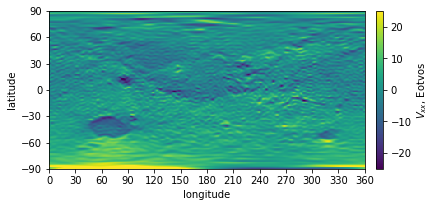

In [14]:
tensor = bouguer.tensor(lmax=95)
fig8, ax8 = tensor.plot_vxx(vmin=-25, vmax=25)

The three eigenvalues of the gravity tensor, as well as the three invariants, can be computed with the methods `compute_eig()` and `compute_invar()`. Here, we plot the maximum eigenvalue that is associated with Bouguer anomaly:

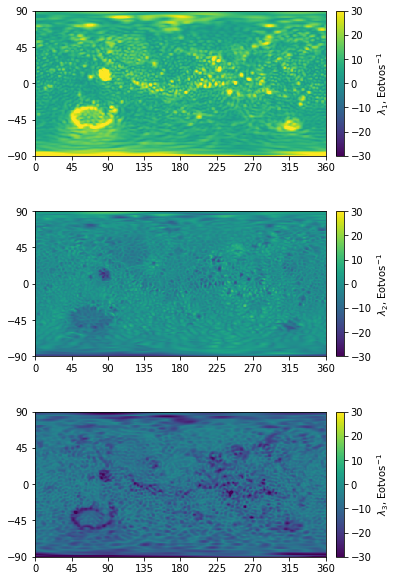

In [15]:
fig9, ax9 = tensor.plot_eigs(vmin=-30, vmax=30, show=False)
fig9.set_figheight(8.5)

Lastly, the `GravTensor` class allows one to compute the horizontal eigenvalues. In contrast to the eigenvaules calculated above, these are computed from using only the horizonal components of the tensor $V_{xx}$, $V_{xy}$, $V_{yx}$, and $V_{yy}$. Here we plot the maximum and minimum horizontal eigenvalues, $\lambda_{h1}$ and $\lambda_{h2}$:

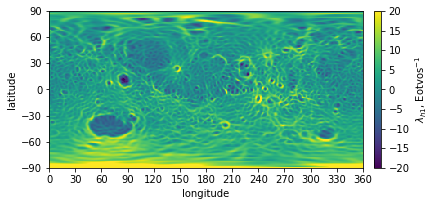

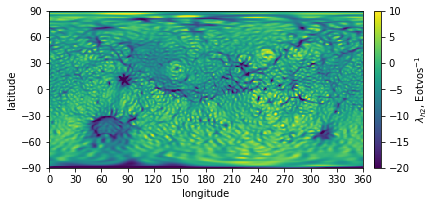

In [16]:
fig10, ax10 = tensor.plot_eigh1(vmin=-20, vmax=20)
fig11, ax11 = tensor.plot_eigh2(vmin=-20, vmax=10)